In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import entropy

class CheckBalance:
    def __init__(self, filepath, activity_threshold):
        self.filepath = filepath
        self.activity_threshold = activity_threshold
        self.data = self.load_data()

    def load_data(self):
        # Load only the necessary columns
        columns = ['chembl_id', 'molregno', 'target_kinase', 'canonical_smiles',
                   'standard_value', 'standard_type', 'kinase_group']
        return pd.read_csv(self.filepath, sep='\t', usecols=columns, low_memory=False)

    def prepare_labels(self):
        # Ensure the standard_value column is numeric
        self.data['standard_value'] = pd.to_numeric(self.data['standard_value'], errors='coerce')
        # Prepare labels based on activity thresholds
        self.data['label'] = self.data['standard_value'].apply(lambda x: 'active' if pd.notna(x) and x < self.activity_threshold else 'inactive')

    def filter_relevant_groups(self):
        # Define the relevant kinase groups
        relevant_kinase_groups = [
            'AGC', 'Other', 'TKL', 'CAMK', 'CK1', 'CMGC', 'STE', 'Tyrosine',
            'Transferse', 'Serine', 'Nuclear', 'Lyase'
        ]
        self.data = self.data[self.data['kinase_group'].isin(relevant_kinase_groups)]

    def analyze_class_balance(self):
        # Ensure labels are prepared
        if 'label' not in self.data.columns:
            self.prepare_labels()

        # Filter the kinase groups to exclude irrelevant ones
        self.filter_relevant_groups()

        # Analyze class balance within each kinase group
        class_counts = self.data.groupby(['kinase_group', 'label']).size().unstack(fill_value=0)

        return self.data

    def analyze_class_metrics(self):
        # Ensure labels are prepared
        if 'label' not in self.data.columns:
            self.prepare_labels()

        # Calculate class counts and ratios
        class_counts = self.data['label'].value_counts()
        class_ratio = class_counts['active'] / class_counts['inactive'] if 'active' in class_counts and 'inactive' in class_counts else float('inf')

        # Calculate entropy
        probability_distribution = class_counts / class_counts.sum()
        data_entropy = entropy(probability_distribution, base=2)

        # Calculate the coefficient of variation
        coeff_variation = np.std(class_counts) / np.mean(class_counts)

        results = pd.DataFrame({
            "Metric": ["Class Ratio", "Entropy of Distribution", "Coefficient of Variation"],
            "Value": [class_ratio, data_entropy, coeff_variation]
        })
        results.to_csv(f'data_balance_statistics_{self.activity_threshold}.tsv', sep='\t', index=False)

    def save_output(self):
        if 'label' not in self.data.columns:
            self.prepare_labels()

        self.filter_relevant_groups()
        self.data.to_csv(f'filtered_dataset_{self.activity_threshold}.tsv', sep="\t", index=False)

def run_analysis(activity_threshold, filepath):

    checker = CheckBalance(filepath, activity_threshold)
    checker.save_output()  # Save the output with specific rows removed
    checker.analyze_class_metrics()  # Calculate and save class metrics
    data = checker.analyze_class_balance()  # Analyze and return data for balance comparison
    return data

def plot_combined_results(data_1000, data_10000):
    # Combine datasets
    data_1000['threshold'] = '1 uM'
    data_10000['threshold'] = '10 uM'
    combined_data = pd.concat([data_1000, data_10000])

    # Plot overall class balance
    plt.figure(figsize=(12, 6))
    sns.countplot(data=combined_data, x='label', hue='threshold', palette='Blues', dodge=True)
    plt.title('Overall Class Balance')
    plt.xlabel('Activity Class')
    plt.ylabel('Number of Compounds')
    plt.legend(title='Threshold')
    plt.savefig('class_balance_overall_combined.png')
    plt.show()

    # Plot box plot for standard value by activity class
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=combined_data, x='label', y='standard_value', hue='threshold', palette='Blues')
    plt.title('Box Plot of Standard Value by Activity Class')
    plt.xlabel('Activity Class')
    plt.ylabel('Standard Value')
    plt.yscale('log')
    plt.savefig('boxplot_standard_value_by_label_combined.png')
    plt.show()

    # Plot distribution of activity classes within relevant kinase groups for each threshold separately
    fig, axes = plt.subplots(2, 1, figsize=(14, 16))

    sns.histplot(data=data_10000, x='kinase_group', hue='label', multiple="dodge", shrink=.8, palette='Blues', hue_order=['active', 'inactive'], ax=axes[0])
    axes[0].set_title('Distribution of Activity Classes within Relevant Kinase Groups (10000 nM)')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_xlabel('Kinase Group')
    axes[0].set_ylabel('Count')
    axes[0].set_yscale('log')
    # axes[0].legend(title='Activity Class')

    sns.histplot(data=data_1000, x='kinase_group', hue='label', multiple="dodge", shrink=.8, palette='Blues', hue_order=['active', 'inactive'], ax=axes[1])
    axes[1].set_title('Distribution of Activity Classes within Relevant Kinase Groups (1000 nM)')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    axes[1].set_xlabel('Kinase Group')
    axes[1].set_ylabel('Count')
    axes[1].set_yscale('log')
    # axes[1].legend(title='Activity Class')

    plt.tight_layout()
    plt.savefig('distribution_activity_classes_kinase_groups_combined.png')
    plt.show()


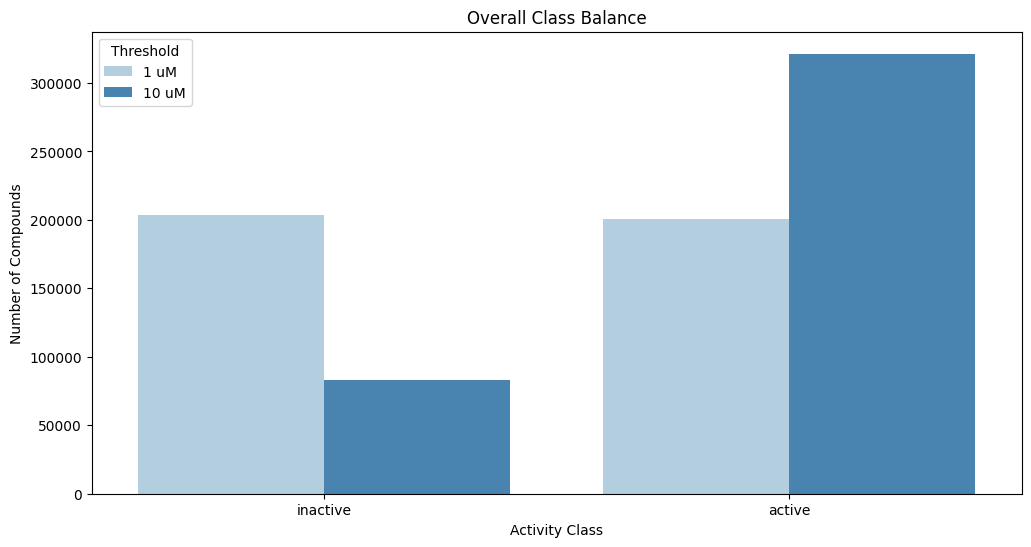

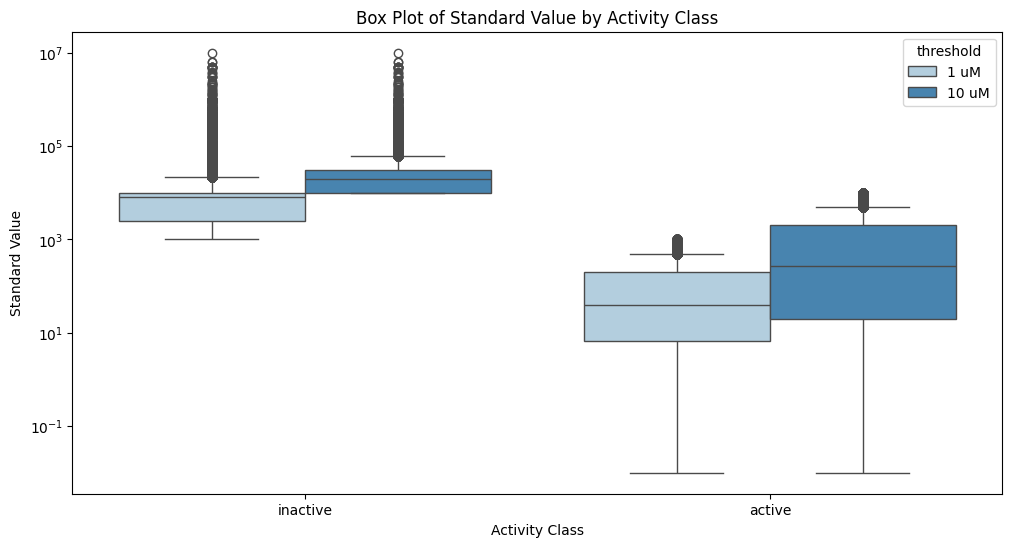

<ipython-input-21-76e478840579>:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-21-76e478840579>:122: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


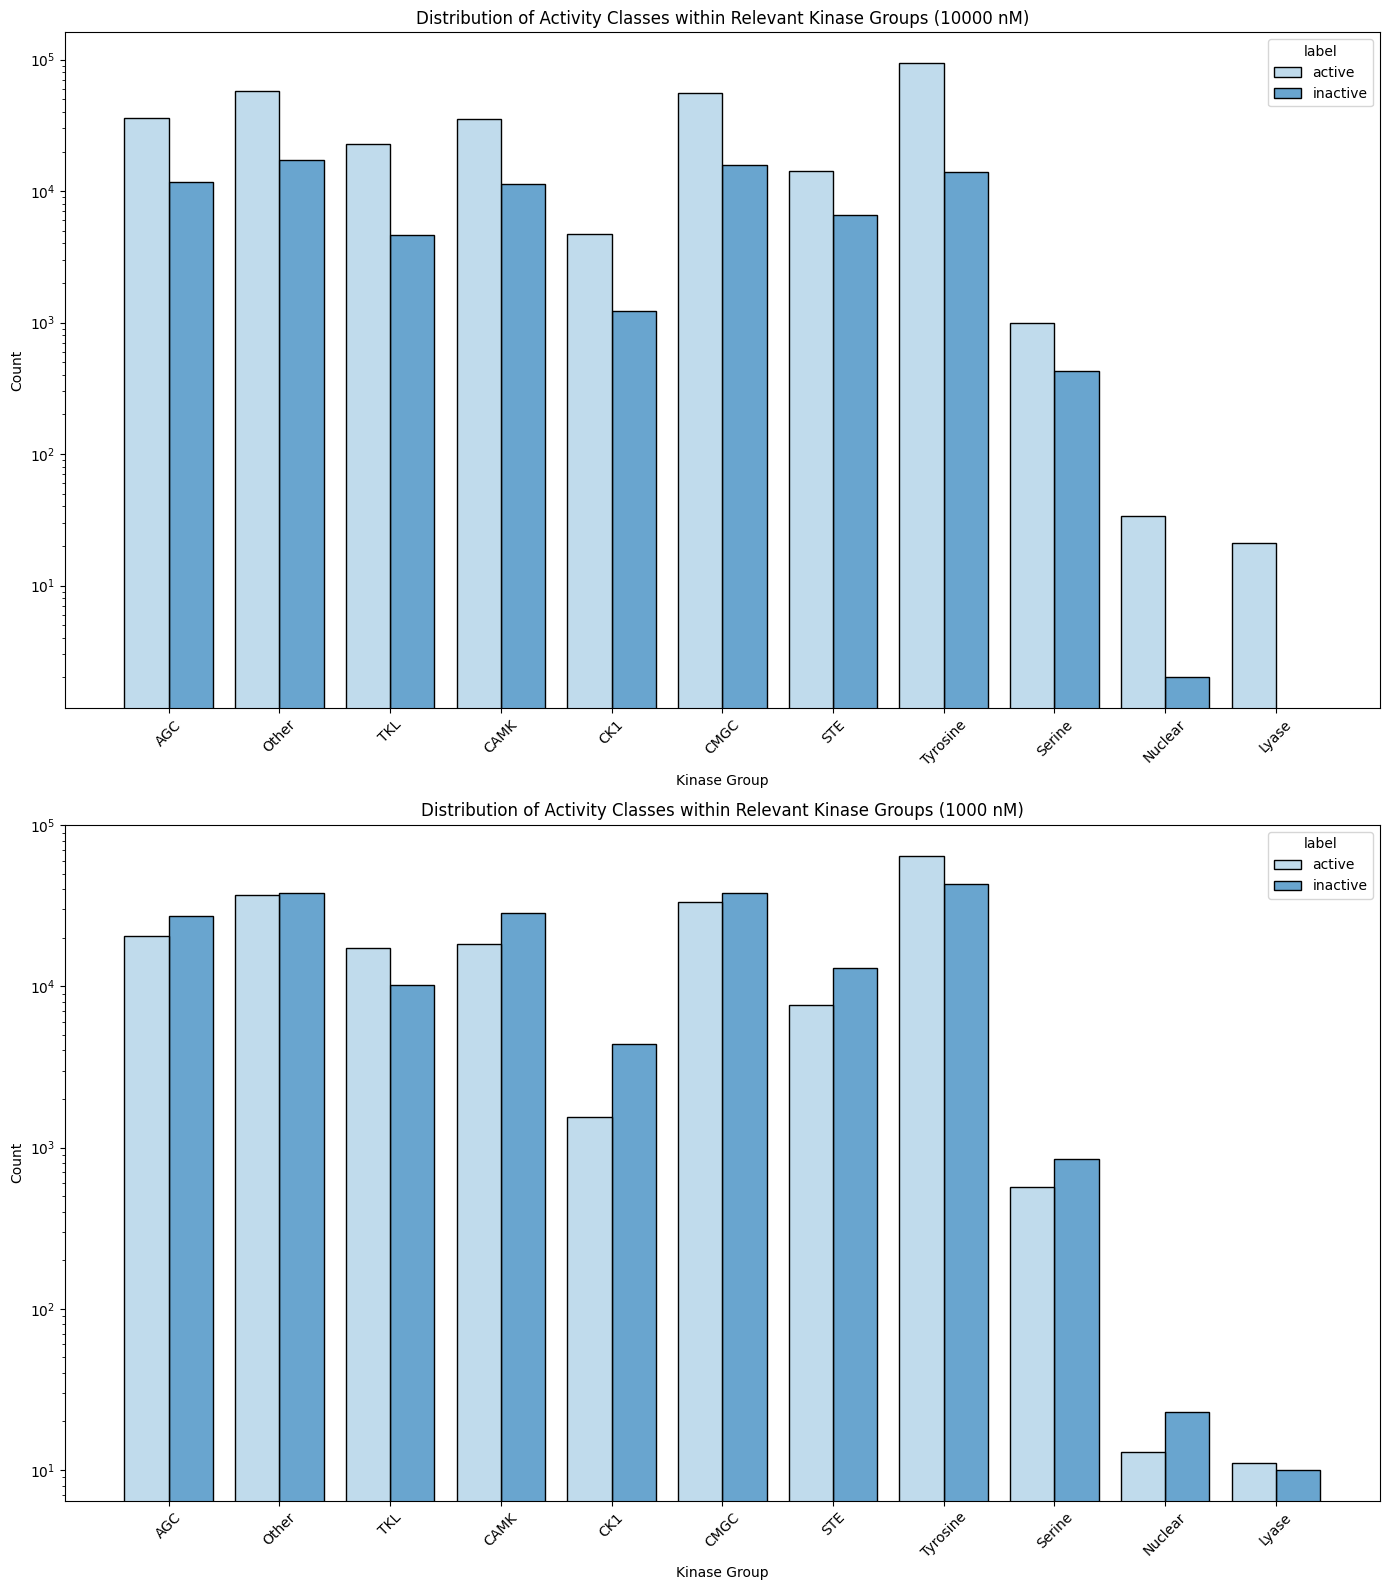

In [ ]:

def main():

    filepath = '/content/nr_kinase_all_compounds_salt_free_ver2.tsv'

    data_1000 = run_analysis(1000, filepath)
    data_10000 = run_analysis(10000, filepath)  # Set activity threshold for nM (e.g., 10µM expressed as 10000 nM)

    plot_combined_results(data_1000, data_10000)

if __name__:
    main()


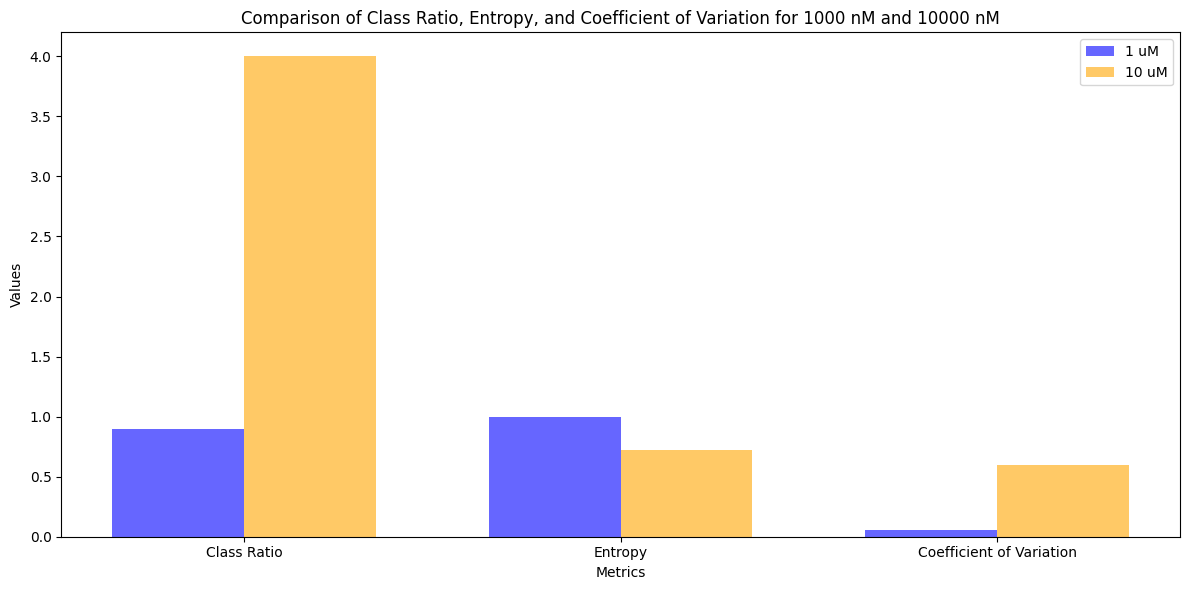

In [ ]:
import matplotlib.pyplot as plt

# Dados fornecidos
class_ratio_1000 = 0.900504
entropy_1000 = 0.998022
variation_1000 = 0.052352

class_ratio_10000 = 3.999887
entropy_10000 = 0.721937
variation_10000 = 0.599991

# Dados para plotar
labels = ['Class Ratio', 'Entropy', 'Coefficient of Variation']
values_1000 = [class_ratio_1000, entropy_1000, variation_1000]
values_10000 = [class_ratio_10000, entropy_10000, variation_10000]

# Plotting
x = range(len(labels))

fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plots
bar_width = 0.35
bar_1000 = ax.bar(x, values_1000, width=bar_width, label='1 uM', color='blue', alpha=0.6)
bar_10000 = ax.bar([p + bar_width for p in x], values_10000, width=bar_width, label='10 uM', color='orange', alpha=0.6)

# Add some text for labels, title and axes ticks
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Class Ratio, Entropy, and Coefficient of Variation for 1000 nM and 10000 nM')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

### Justificativa para Escolher 1000 nM

Escolher o limiar de 1000 nM como um critério de atividade pode ser uma escolha mais racional para modelos de aprendizado de máquina de classificação múltipla pelos seguintes motivos:

### 1. Distribuição Mais Equilibrada das Classes
A principal vantagem de escolher o limiar de 1000 nM é a distribuição mais equilibrada entre compostos ativos e inativos. Conforme observado nas estatísticas:

- **Class Ratio (Razão de Classes):** 0.900504
  - Uma razão próxima de 1 indica que o número de compostos ativos e inativos é bastante equilibrado.
- **Entropy of Distribution (Entropia da Distribuição):** 0.998022
  - Alta entropia sugere que a distribuição das classes é mais uniforme e menos previsível, o que é benéfico para modelos de aprendizado de máquina que requerem um conjunto de dados balanceado.
- **Coefficient of Variation (Coeficiente de Variação):** 0.052352
  - Um coeficiente de variação baixo indica consistência na distribuição das classes, o que reduz o risco de viés nos modelos.

### 2. Melhor Desempenho do Modelo
Modelos de aprendizado de máquina, especialmente os de classificação, tendem a se beneficiar de conjuntos de dados balanceados pelos seguintes motivos:

- **Generalização:** Modelos treinados em conjuntos de dados equilibrados são mais propensos a generalizar bem para novos dados, pois não foram treinados com um viés significativo em direção a uma classe específica.
- **Redução de Viés:** Com um número equilibrado de exemplos de cada classe, o modelo pode aprender de forma mais justa e precisa, evitando sobreajuste a uma classe dominante.

### 3. Facilidade de Avaliação
A avaliação de modelos de classificação é mais direta e confiável quando as classes são equilibradas:

- **Métricas de Desempenho:** Métricas como precisão, recall, F1-score e AUC-ROC são mais representativas e confiáveis em conjuntos de dados balanceados. Em um conjunto de dados desbalanceado, uma alta precisão pode ser ilusória, pois o modelo pode estar simplesmente prevendo a classe majoritária.
- **Interpretação dos Resultados:** Com classes balanceadas, a interpretação dos resultados do modelo se torna mais intuitiva e representativa do desempenho real em diferentes classes.

### 4. Mitigação da Necessidade de Técnicas de Rebalanceamento
Conjuntos de dados desbalanceados frequentemente exigem técnicas adicionais para balancear as classes, como:

- **Amostragem:** Sobreamostragem da classe minoritária ou subamostragem da classe majoritária.
- **Ajuste de Pesos:** Ajuste de pesos durante o treinamento para dar mais importância à classe minoritária.

Essas técnicas podem ser eficazes, mas adicionam complexidade ao processo de modelagem e podem introduzir outros desafios, como o risco de overfitting com sobreamostragem.

### Comparação com o Limiar de 10000 nM
Para contrastar, o limiar de 10000 nM apresenta um desequilíbrio significativo:

- **Class Ratio:** 3.999887
  - Há quatro vezes mais compostos ativos do que inativos, indicando um forte desbalanceamento.
- **Entropy of Distribution:** 0.721937
  - A entropia mais baixa sugere uma distribuição menos equilibrada, o que pode afetar negativamente o desempenho do modelo.
- **Coefficient of Variation:** 0.599991
  - Alta variação indica maior discrepância entre as quantidades das classes, o que pode introduzir viés e dificultar a generalização do modelo.

Por essas razões, escolher o limiar de 1000 nM é uma escolha mais racional para obter um conjunto de dados mais equilibrado e robusto para modelos de aprendizado de máquina.

Escolher o limiar de 1000 nM como um critério de atividade pode ser uma escolha mais racional para modelos de aprendizado de máquina de classificação múltipla pelos seguintes motivos:

### 1. Distribuição Mais Equilibrada das Classes
A principal vantagem de escolher o limiar de 1000 nM é a distribuição mais equilibrada entre compostos ativos e inativos. Conforme observado nas estatísticas:

- **Class Ratio (Razão de Classes):** 0.900504
  - Uma razão próxima de 1 indica que o número de compostos ativos e inativos é bastante equilibrado.
- **Entropy of Distribution (Entropia da Distribuição):** 0.998022
  - Alta entropia sugere que a distribuição das classes é mais uniforme e menos previsível, o que é benéfico para modelos de aprendizado de máquina que requerem um conjunto de dados balanceado.
- **Coefficient of Variation (Coeficiente de Variação):** 0.052352
  - Um coeficiente de variação baixo indica consistência na distribuição das classes, o que reduz o risco de viés nos modelos.

### 2. Melhor Desempenho do Modelo
Modelos de aprendizado de máquina, especialmente os de classificação, tendem a se beneficiar de conjuntos de dados balanceados pelos seguintes motivos:

- **Generalização:** Modelos treinados em conjuntos de dados equilibrados são mais propensos a generalizar bem para novos dados, pois não foram treinados com um viés significativo em direção a uma classe específica.
- **Redução de Viés:** Com um número equilibrado de exemplos de cada classe, o modelo pode aprender de forma mais justa e precisa, evitando sobreajuste a uma classe dominante.

### 3. Facilidade de Avaliação
A avaliação de modelos de classificação é mais direta e confiável quando as classes são equilibradas:

- **Métricas de Desempenho:** Métricas como precisão, recall, F1-score e AUC-ROC são mais representativas e confiáveis em conjuntos de dados balanceados. Em um conjunto de dados desbalanceado, uma alta precisão pode ser ilusória, pois o modelo pode estar simplesmente prevendo a classe majoritária.
- **Interpretação dos Resultados:** Com classes balanceadas, a interpretação dos resultados do modelo se torna mais intuitiva e representativa do desempenho real em diferentes classes.

### 4. Mitigação da Necessidade de Técnicas de Rebalanceamento
Conjuntos de dados desbalanceados frequentemente exigem técnicas adicionais para balancear as classes, como:

- **Amostragem:** Sobreamostragem da classe minoritária ou subamostragem da classe majoritária.
- **Ajuste de Pesos:** Ajuste de pesos durante o treinamento para dar mais importância à classe minoritária.

Essas técnicas podem ser eficazes, mas adicionam complexidade ao processo de modelagem e podem introduzir outros desafios, como o risco de overfitting com sobreamostragem.

### Comparação com o Limiar de 10000 nM
Para contrastar, o limiar de 10000 nM apresenta um desequilíbrio significativo:

- **Class Ratio:** 3.999887
  - Há quatro vezes mais compostos ativos do que inativos, indicando um forte desbalanceamento.
- **Entropy of Distribution:** 0.721937
  - A entropia mais baixa sugere uma distribuição menos equilibrada, o que pode afetar negativamente o desempenho do modelo.
- **Coefficient of Variation:** 0.599991
  - Alta variação indica maior discrepância entre as quantidades das classes, o que pode introduzir viés e dificultar a generalização do modelo.

### Conclusão
Dado o equilíbrio de classes proporcionado pelo limiar de 1000 nM, escolher esse limiar resulta em uma distribuição mais uniforme das classes. Isso facilita a construção de modelos de aprendizado de máquina mais robustos, precisos e generalizáveis, tornando-o uma escolha mais racional para a classificação múltipla em estudos de bioatividade de compostos.

# ML analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_train_test(bits, rf_train, lr_train, dt_train, nb_train, ovr_train, rf_test, lr_test, dt_test, nb_test, ovr_test):
    # Preparar dados para o plot
    data_test = {
        'Bits': bits * 5,
        'Accuracy': rf_test + lr_test + dt_test + nb_test + ovr_test,
        'Model': ['Random Forest'] * len(bits) + ['Logistic Regression'] * len(bits) + ['Decision Tree'] * len(bits) + ['Naive Bayes'] * len(bits) + ['One-vs-Rest'] * len(bits)
    }

    data_train = {
        'Bits': bits * 5,
        'Accuracy': rf_train + lr_train + dt_train + nb_train + ovr_train,
        'Model': ['Random Forest'] * len(bits) + ['Logistic Regression'] * len(bits) + ['Decision Tree'] * len(bits) + ['Naive Bayes'] * len(bits) + ['One-vs-Rest'] * len(bits)
    }

    df_test = pd.DataFrame(data_test)
    df_train = pd.DataFrame(data_train)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

    # Plot do conjunto de treino
    sns.pointplot(ax=axs[0], x='Bits', y='Accuracy', hue='Model', data=df_train, markers=['o', 's', 'D', '^', 'v'], linestyles=['-', '--', '-.', ':', '-'])
    axs[0].set_title('Model Performance by Number of Bits in Fingerprint (Train)')
    axs[0].set_xlabel('Fingerprint (bits)')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[0].grid(True)

    # Plot do conjunto de teste
    sns.pointplot(ax=axs[1], x='Bits', y='Accuracy', hue='Model', data=df_test, markers=['o', 's', 'D', '^', 'v'], linestyles=['-', '--', '-.', ':', '-'])
    axs[1].set_title('Model Performance by Number of Bits in Fingerprint (Test)')
    axs[1].set_xlabel('Fingerprint (bits)')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[1].grid(True)

    plt.tight_layout()
    plt.savefig('./fingerprint_ML_train_test.png')
    plt.show()

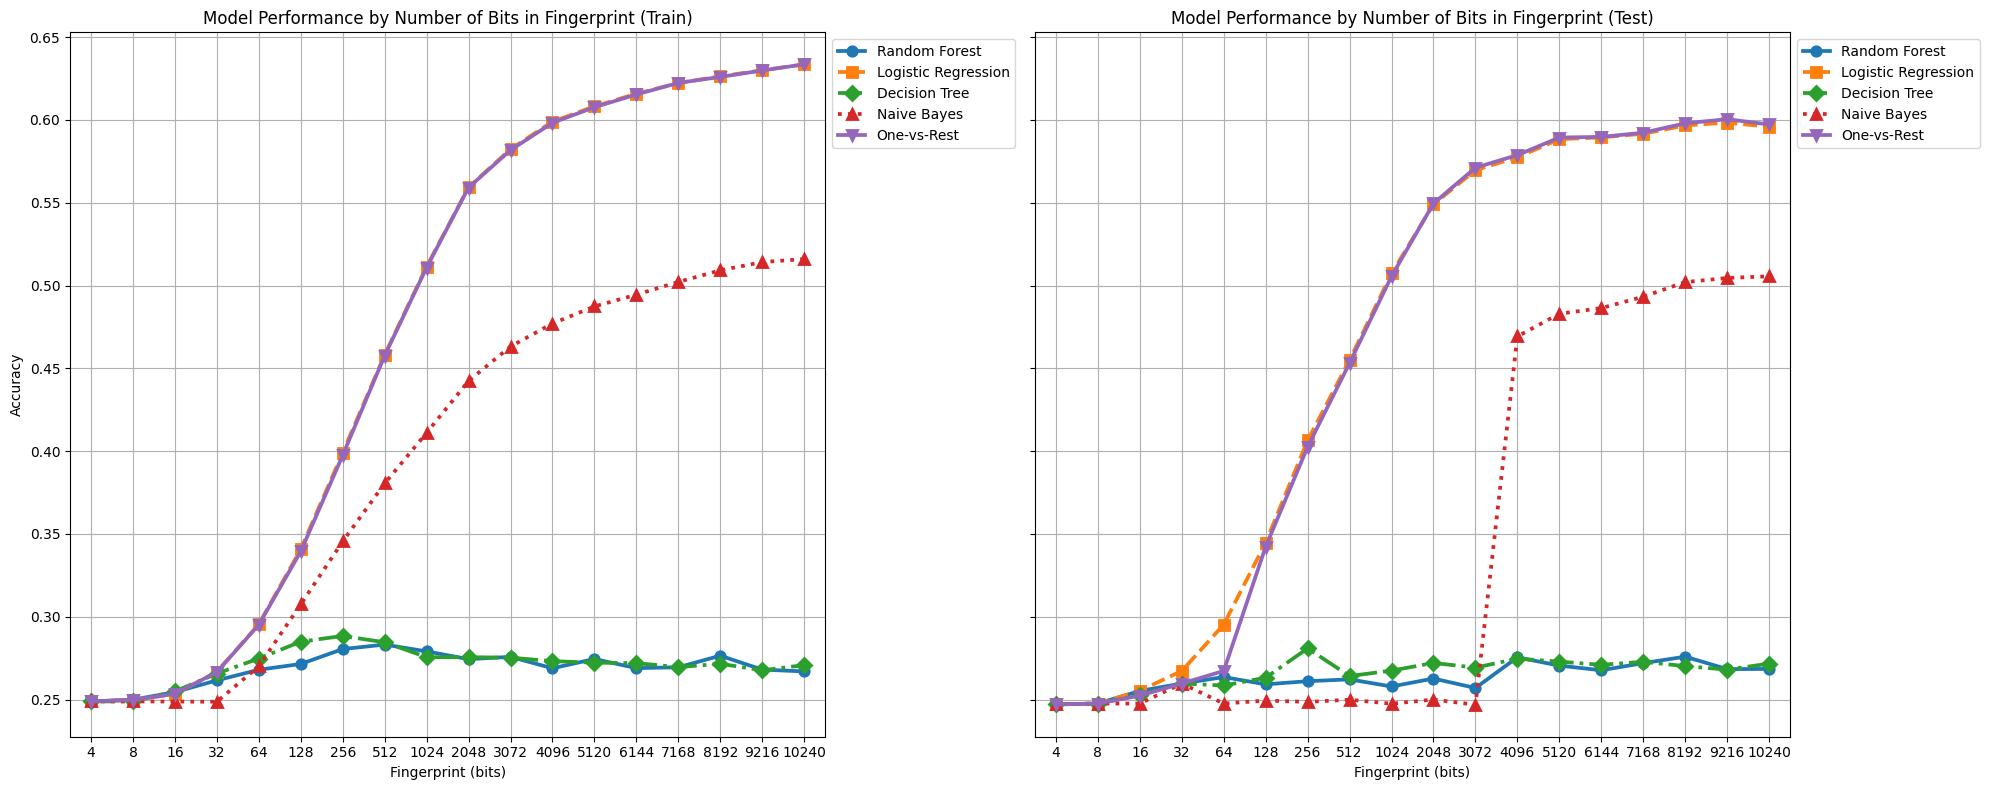

In [ ]:
if __name__ == "__main__":
    # Dados fornecidos
    bits = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192, 9216, 10240]

    random_forest_train       = [0.2489, 0.2499, 0.2545, 0.2616, 0.2680, 0.2715, 0.2805, 0.2832, 0.2791, 0.2744, 0.2758, 0.2689, 0.2745, 0.2690, 0.2695, 0.2765, 0.2681, 0.2670]
    logistic_regression_train = [0.2489, 0.2498, 0.2533, 0.2668, 0.2955, 0.3408, 0.3991, 0.4582, 0.5115, 0.5594, 0.5824, 0.5990, 0.6082, 0.6159, 0.6223, 0.6264, 0.6300, 0.6336]
    decision_tree_train       = [0.2489, 0.2489, 0.2549, 0.2657, 0.2748, 0.2850, 0.2884, 0.2846, 0.2756, 0.2756, 0.2753, 0.2732, 0.2723, 0.2720, 0.2696, 0.2716, 0.2677, 0.2708]
    naive_bayes_train         = [0.2489, 0.2489, 0.2488, 0.2487, 0.2701, 0.3075, 0.3455, 0.3805, 0.4111, 0.4424, 0.4632, 0.4771, 0.4874, 0.4945, 0.5022, 0.5092, 0.5142, 0.5160]
    one_vs_rest_train         = [0.2489, 0.2498, 0.2534, 0.2666, 0.2952, 0.3395, 0.3975, 0.4577, 0.5109, 0.5592, 0.5818, 0.5983, 0.6077, 0.6154, 0.6224, 0.6260, 0.6299, 0.6336]


    random_forest_test       = [0.2471, 0.2476, 0.2552, 0.2597, 0.2636, 0.2592, 0.2611, 0.2622, 0.2579, 0.2627, 0.2570, 0.2755, 0.2705, 0.2677, 0.2720, 0.2759, 0.2684, 0.2685]
    logistic_regression_test = [0.2471, 0.2476, 0.2553, 0.2673, 0.2953, 0.3448, 0.4065, 0.4550, 0.5073, 0.5491, 0.5697, 0.5775, 0.5884, 0.5895, 0.5917, 0.5967, 0.5984, 0.5959]
    decision_tree_test       = [0.2471, 0.2476, 0.2528, 0.2597, 0.2585, 0.2632, 0.2809, 0.2642, 0.2675, 0.2721, 0.2693, 0.2747, 0.2729, 0.2710, 0.2728, 0.2702, 0.2681, 0.2717]
    naive_bayes_test         = [0.2471, 0.2476, 0.2476, 0.2597, 0.2476, 0.2494, 0.2486, 0.2499, 0.2475, 0.2500, 0.2469, 0.4693, 0.4830, 0.4864, 0.4933, 0.5021, 0.5046, 0.5056]
    one_vs_rest_test         = [0.2471, 0.2476, 0.2524, 0.2597, 0.2673, 0.3423, 0.4026, 0.4532, 0.5056, 0.5496, 0.5712, 0.5788, 0.5894, 0.5898, 0.5923, 0.5980, 0.6005, 0.5973]

    plot_train_test(bits, random_forest_train, logistic_regression_train,
                    decision_tree_train, naive_bayes_train, one_vs_rest_train,
                    random_forest_test, logistic_regression_test, decision_tree_test,
                    naive_bayes_test, one_vs_rest_test)

### Discussão dos Resultados dos Algoritmos de Aprendizado de Máquina

### Justificativas para o Desempenho dos Algoritmos

#### 1. **Random Forest e Decision Tree:**
Esses algoritmos apresentaram desempenho ruim tanto no treino quanto no teste.

- **Overfitting e Underfitting:**
  - **Overfitting:** Com um pequeno número de bits, as árvores de decisão podem se ajustar demais aos dados de treino, capturando o ruído ao invés de padrões reais. À medida que o número de bits aumenta, o modelo ainda pode não capturar bem a complexidade dos dados devido à alta dimensionalidade, resultando em uma capacidade preditiva pobre.
  - **Underfitting:** Os modelos podem não estar capturando suficientemente a complexidade dos dados. Árvores de decisão e florestas aleatórias requerem uma boa quantidade de variação nos dados para generalizar bem, e poucos bits podem não fornecer informações suficientes.

- **Desempenho Consistente:** O desempenho consistentemente ruim pode ser devido à incapacidade dos modelos de capturar relações não lineares complexas em conjuntos de dados de alta dimensionalidade.

#### 2. **Naive Bayes:**
O Naive Bayes teve desempenho razoável no treino, mas muito ruim no teste.

- **Suposição de Independência:**
  - O Naive Bayes assume que todas as características são independentes, o que raramente é verdade para dados reais. Esta suposição pode funcionar para conjuntos de dados simples, mas falha em capturar a complexidade em dados de alta dimensionalidade.
  - À medida que o número de bits aumenta, a violação dessa suposição de independência se torna mais pronunciada, levando a um desempenho ruim em dados de teste, apesar de parecer razoável em dados de treino.

- **Overfitting em Treino:** O modelo pode estar se ajustando demais aos dados de treino devido ao aumento da dimensionalidade, resultando em uma baixa capacidade de generalização.

#### 3. **Logistic Regression e One-vs-Rest:**
Esses algoritmos apresentaram bom desempenho, melhorando à medida que o número de bits aumenta.

- **Modelos Lineares:**
  - **Logistic Regression:** É robusto para alta dimensionalidade e pode capturar bem a relação linear entre as características e a variável alvo. Com o aumento dos bits, a capacidade do modelo de capturar informações úteis melhora, levando a um melhor desempenho.
  - **One-vs-Rest:** É uma extensão da regressão logística para classificação multiclasse e se beneficia da mesma robustez em alta dimensionalidade.

- **Regularização:** Esses modelos geralmente incluem técnicas de regularização (como L2), que ajudam a evitar overfitting, especialmente em dados de alta dimensionalidade. Isso contribui para a melhora contínua no desempenho conforme o número de bits aumenta.

- **Capacidade de Generalização:** A regressão logística e One-vs-Rest têm uma boa capacidade de generalização, permitindo que se ajustem bem aos dados de treino e também performem bem nos dados de teste, especialmente com um maior número de bits, que fornece mais informações discriminativas.

### Conclusão

- **Random Forest e Decision Tree:** São menos eficazes neste cenário devido ao overfitting com poucos bits e underfitting com muitos bits, incapazes de capturar relações complexas em alta dimensionalidade.
- **Naive Bayes:** Falha em generalizar devido à suposição de independência das características, que se torna mais problemática com o aumento da dimensionalidade.
- **Logistic Regression e One-vs-Rest:** Desempenham bem devido à sua robustez em alta dimensionalidade, capacidade de capturar relações lineares, e técnicas de regularização que evitam overfitting, resultando em uma melhora contínua conforme o número de bits aumenta.

Essas justificativas destacam a importância de escolher o algoritmo certo com base na natureza dos dados e na capacidade do modelo de capturar padrões complexos sem sobrecarregar com ruído ou suposições inválidas.

In [ ]:
# Load all confusion matrix data from the CSV files
confusion_matrix_ovr = pd.read_csv('/content/confusion_matrix_one-vs-rest.csv')
confusion_matrix_dt = pd.read_csv('/content/confusion_matrix_decision_tree.csv')
confusion_matrix_lr = pd.read_csv('/content/confusion_matrix_logistic_regression.csv')
confusion_matrix_nb = pd.read_csv('/content/confusion_matrix_naive_bayes.csv')

### Explicação Detalhada:

- **True Positives (TP):** Elementos na diagonal principal, onde a classe prevista coincide com a classe verdadeira.
  
- **False Positives (FP):** Elementos fora da diagonal na mesma coluna. Representam as instâncias que foram previstas como pertencentes a uma determinada classe, mas na verdade pertencem a outra classe. Para uma classe \( i \), os FP são todos os elementos da coluna \( i \), exceto o elemento da diagonal \( (i, i) \).

- **False Negatives (FN):** Elementos fora da diagonal na mesma linha. Representam as instâncias que pertencem a uma determinada classe, mas foram previstas como pertencentes a outra classe. Para uma classe \( i \), os FN são todos os elementos da linha \( i \), exceto o elemento da diagonal \( (i, i) \).

- **True Negatives (TN):** Todos os outros elementos que não estão na linha ou coluna do elemento específico. Para uma classe \( i \), os TN são todos os elementos que não estão na linha \( i \) nem na coluna \( i \).

### Exemplo:

Para a classe 0 (primeira linha e coluna):
- **TP:** \( 13312 \) (posição [0,0])
- **FP:** \( 1652, 1841, 1422, 1871 \) etc. (coluna 0, excluindo posição [0,0])
- **FN:** \( 836, 1283, 618, 965 \) etc. (linha 0, excluindo posição [0,0])
- **TN:** Todos os outros elementos que não estão na linha 0 nem na coluna 0.


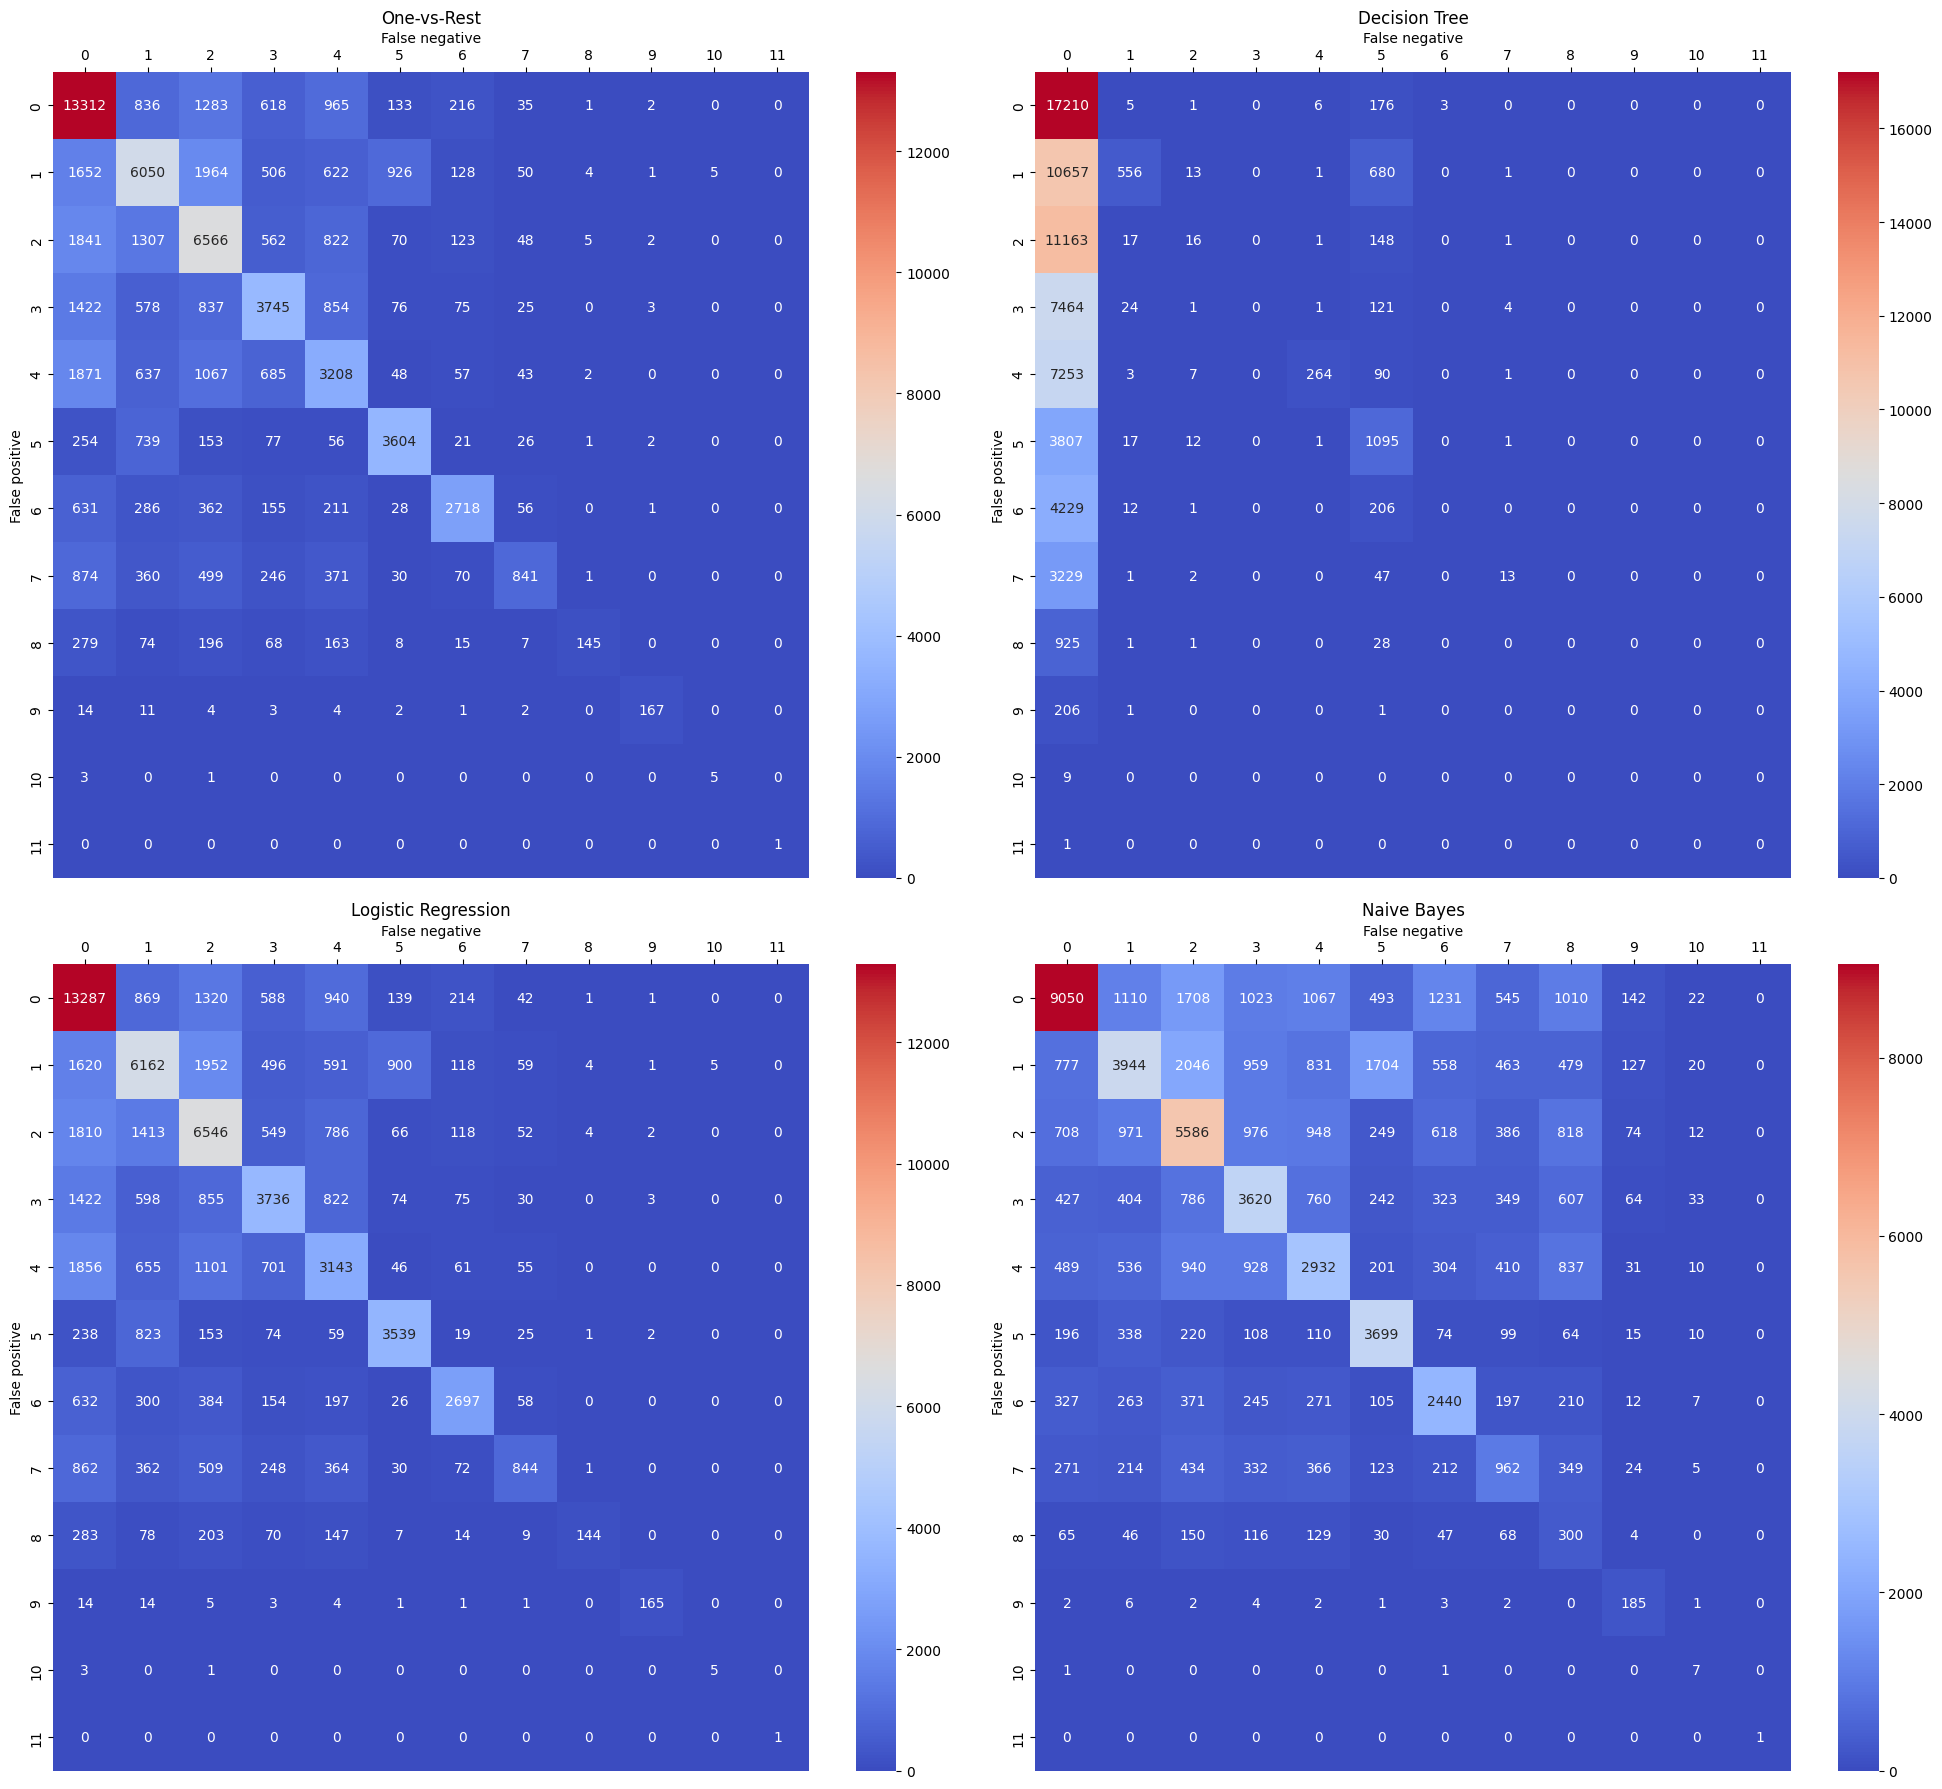

In [ ]:
f# Set up the figure and axes for plotting multiple confusion matrices
fig, axs = plt.subplots(2, 2, figsize=(20, 18))

# Titles for the subplots
titles = ['One-vs-Rest', 'Decision Tree', 'Logistic Regression', 'Naive Bayes']

# List of confusion matrices
confusion_matrices = [confusion_matrix_ovr, confusion_matrix_dt, confusion_matrix_lr, confusion_matrix_nb]

# Loop through the axes and confusion matrices
for ax, cm, title in zip(axs.flat, confusion_matrices, titles):
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('False negative')
    ax.set_ylabel('False positive')
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

# Adjust layout
plt.tight_layout()
plt.show()